In [2]:
# Import necessary libraries
import xarray as xr
import cdsapi
import xarray as xr
import rioxarray
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import os  

In [3]:
# Load India shapefile
india_shapefile = gpd.read_file(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\SHAPEFILE\gadm36_IND_0.shp").to_crs("epsg:4326")
india_geometry = india_shapefile.geometry

In [5]:
# download raw netCDF data 
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            '2m_temperature',
            'total_precipitation'
        ],
        'year': [
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
            '2021', '2022', '2023',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'area': [
            35.5, 68.2, 8, 97.5  # North, West, South, East
        ],
    },
     r'C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\CDS\weather_data.nc'))

2023-11-19 01:09:59,193 INFO Welcome to the CDS
2023-11-19 01:09:59,193 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-11-19 01:09:59,257 INFO Request is queued
2023-11-19 01:10:00,307 INFO Request is running
2023-11-19 01:14:17,773 INFO Request is completed
2023-11-19 01:14:17,775 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data0/adaptor.mars.internal-1700352802.7186775-20398-17-d4ee7537-7cea-49f3-b238-a325a271e699.nc to download.nc (28.6M)
2023-11-19 01:14:19,618 INFO Download rate 15.5M/s  


Result(content_length=29971708,content_type=application/x-netcdf,location=https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data0/adaptor.mars.internal-1700352802.7186775-20398-17-d4ee7537-7cea-49f3-b238-a325a271e699.nc)

In [6]:
# Load Climate data (.nc format)
climate_data = xr.open_dataset(r"C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\CDS\era5_data.nc")

In [7]:
# Convert temperature to celsius  
climate_data['t2m'] = climate_data['t2m'] - 273.15

In [8]:
# clip to shapefile
climate_data_clipped_shapefile = climate_data.rio.write_crs("epsg:4326").rio.clip(india_geometry)

c:\Users\djava\miniconda3\envs\xarray_test\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


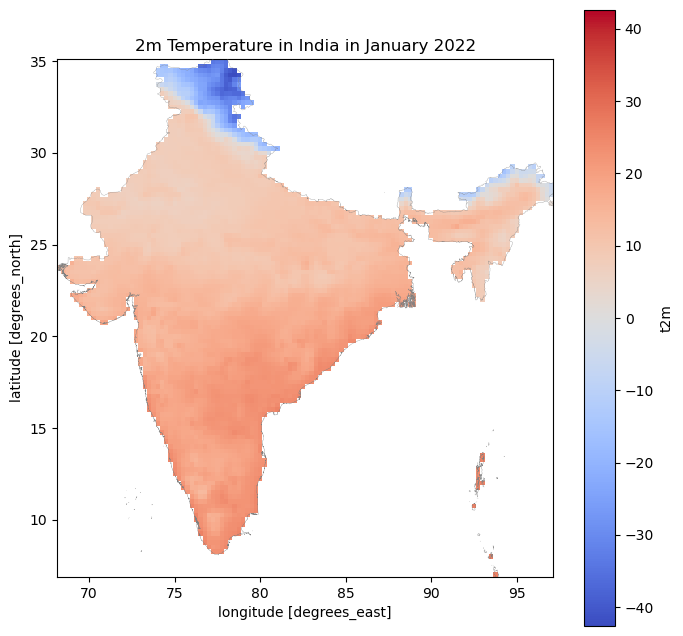

In [12]:
# visualize indian climate data by setting xlim and ylim without cartopy
fig, ax = plt.subplots(figsize=(8, 8))
climate_data_clipped_shapefile["t2m"].sel(time="2022-01", method="nearest").plot(ax=ax, cmap="coolwarm")
india_shapefile.boundary.plot(ax=ax, color='grey', linewidth=0.2, zorder=5)
ax.set_title("2m Temperature in India in January 2022")
plt.show()

In [11]:
# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             '2m_temperature',   # Temperature at 2 meters
#             'total_precipitation'  # Total Precipitation
#         ],
#         'year': [
#             '2000', '2001', '2002', '2003', '2004', '2005', 
#             '2006', '2007', '2008', '2009', '2010', '2011', 
#             '2012', '2013', '2014', '2015', '2016', '2017',
#             '2018', '2019', '2020', '2021', '2022'
#         ],
#         'month': [
#             '01', '02','03','04','05','06','07','08','09','10','11','12'
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area': [
#             35.5, 68.2, 8, 97.5  # North, West, South, East
#         ],
#     },
#     r'C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\CDS\era5_data_2000_2005.nc')